In [1]:
from pandas_datareader import data
import datetime
import pandas as pd 
import numpy as np
from functools import partial
import random
import utilities as utils

In [2]:
end = datetime.date.today()
begin=end-pd.DateOffset(365)
startDate=begin.strftime('%Y-%m-%d')
endDate=end.strftime('%Y-%m-%d')

priceList = []
tickers = ['EURJPY', 'EURUSD', 'EURAUD', 'USDJPY', 'GBPUSD', 'AUDUSD']
append = '%3DX'

for ticker in tickers:
    df = data.DataReader(name=ticker+append, data_source = 'yahoo', start = startDate, end = endDate)
    df['ticker'] = ticker
    priceList.append(df)

prices = pd.concat(priceList, axis = 0).reset_index()
prices.columns = ['date', 'h', 'l', 'o', 'c', 'v', 'ac', 'ticker']
prices['date'] = pd.to_datetime(prices['date'])
closures = prices[['date', 'ticker', 'c']]
maxima = prices[['date', 'ticker', 'h']]
minima = prices[['date', 'ticker', 'l']]

closuresToWide = closures.pivot(index=['date'], columns=['ticker'], values=['c']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)
maxToWide = maxima.pivot(index=['date'], columns=['ticker'], values=['h']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)
minToWide = minima.pivot(index=['date'], columns=['ticker'], values=['l']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)

maxStaticDistrParams = {'avg' : np.mean(maxToWide.drop(columns=['date'])), 'sd': np.std(maxToWide.drop(columns=['date']))}
minStaticDistrParams = {'avg' : np.mean(maxToWide.drop(columns=['date'])), 'sd': np.std(maxToWide.drop(columns=['date']))}
closeStaticDistrParams = {'avg' : np.mean(maxToWide.drop(columns=['date'])), 'sd': np.std(maxToWide.drop(columns=['date']))}

maxToWideStandardized = maxToWide.drop(columns=['date']).sub(np.array(maxStaticDistrParams['avg']), axis = 'columns')/np.array(maxStaticDistrParams['sd'])
minToWideStandardized = minToWide.drop(columns=['date']).sub(np.array(minStaticDistrParams['avg']), axis = 'columns')/np.array(minStaticDistrParams['sd'])
closeToWideStandardized = closuresToWide.drop(columns=['date']).sub(np.array(closeStaticDistrParams['avg']), axis = 'columns')/np.array(closeStaticDistrParams['sd'])

C:\Users\daniele.sicoli\AppData\Local\Temp\ipykernel_22868\2590562457.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  closuresToWide = closures.pivot(index=['date'], columns=['ticker'], values=['c']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)
C:\Users\daniele.sicoli\AppData\Local\Temp\ipykernel_22868\2590562457.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  maxToWide = maxima.pivot(index=['date'], columns=['ticker'], values=['h']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)
C:\Users\daniele.sicoli\AppData\Local\Temp\ipykernel_22868\2590562457.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  minToWide = minima.pivot(index=['date'], columns=['ticker'], values=['l']).droplevel(level=[0], axis = 1).reset_index().copy().dropna(0)
c:\Users\daniele.sicoli\Documents\prj\data

In [3]:
########################## Calculates portfolio returns ##########################
r_closures = utils.CalculateReturns(closeToWideStandardized)
r_max = utils.CalculateReturns(maxToWideStandardized)
r_min = utils.CalculateReturns(minToWideStandardized)

<AxesSubplot:>

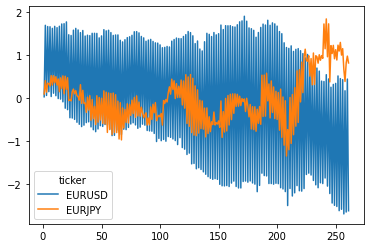

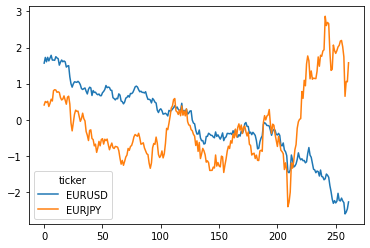

In [4]:
vol_max = r_max.copy().std()
vol_min = r_min.copy().std()
vol_closures = r_closures.copy().std()

vol_max = utils.StdRolling(r_max, r_max.shape[0]).dropna()
vol_min = utils.StdRolling(r_min, r_min.shape[0]).dropna()
vol_closures = utils.StdRolling(r_closures, r_closures.shape[0]).dropna()

cor_max = r_max.copy().corr(method='pearson')
cor_min = r_min.copy().corr(method='pearson')
cor_closures = r_closures.copy().corr(method='pearson')


r_max.plot(y = ['EURUSD', 'EURJPY'])
closeToWideStandardized.plot(y = ['EURUSD', 'EURJPY'])


In [5]:
q = 0.9
thresholdMax = r_max.apply(partial(np.quantile, q = q), axis = 0)
thresholdMax = 0.01 * np.mean(thresholdMax)
thresholdMin =r_min.apply(partial(np.quantile, q = 1.-q), axis = 0)
thresholdMin = 0.01 * np.mean(thresholdMin)
thresholdClosures = r_closures.apply(partial(np.quantile, q = q), axis = 0)
threshold = 0.01 * np.mean(thresholdMax)/3
thresholdMax, thresholdMin, threshold

(0.01216858371544908, -0.010690278977016828, 4.05619457181636e-05)

In [6]:

# def CalculateDayDirectionSimple(time, priceTs):
#     direction = 1 * (priceTs.c.values[time] - priceTs.o.values[time] > 0.) - 1 * (priceTs.c.values[time] - priceTs.o.values[time] < 0.) 
#     ret_t =priceTs.c.values[time] - priceTs.o.values[time]
#     return direction, ret_t

# def CalculateDayDirectionCustom(time, priceTs):
#     direction = 1 * (priceTs.c.values[time] - priceTs.o.values[time] >= 0.) * (priceTs.h.values[time] + priceTs.l.values[time] - 2 * priceTs.o.values[time] >= 0.) - \
#         1 * (priceTs.c.values[time] - priceTs.o.values[time] < 0.) * (priceTs.h.values[time] + priceTs.l.values[time] - 2 * priceTs.o.values[time] < 0.)
#     ret_t =priceTs.c.values[time] - priceTs.o.values[time]
#     return direction, ret_t

# def CalculateOverallDirection(prices, tickers, method = 'custom'):
#     calculationMethod = {
#         'custom': CalculateDayDirectionCustom,
#         'simple': CalculateDayDirectionSimple
#     }
#     CalculatePointDirection = calculationMethod[method]
#     returnsWithDirsLst = []
#     for k, ticker in enumerate(tickers):
#         ret = []
#         dirs = []
#         priceTs = prices.loc[prices.ticker == ticker]
        
#         for i in range(0, priceTs.shape[0]):
#             dir_i, ret_i = CalculatePointDirection(i, priceTs)
#             ret.append(ret_i)
#             dirs.append(dir_i)

#         retDirDf = pd.DataFrame(data = np.array([ret, dirs]).T, columns = ['ret', 'dirs'])
#         retDirDf['ticker'] = ticker
#         retDirDf['date'] = priceTs.date.reset_index()['date']
#         #print(p.date.reset_index()['date'])
#         retDirDf = retDirDf[['ticker', 'date', 'ret', 'dirs']]
#         returnsWithDirsLst.append(retDirDf)
#         returnsWithDirs = pd.concat(returnsWithDirsLst, axis = 0)

#         #print(f'{k}-th weight: {w[k]}; total ret {np.sum(retDf.ret)}')
#     return returnsWithDirs

In [7]:
w = np.array([random.randint(-1, 1) for _ in range(0, r_max.shape[1])])

slBuy = thresholdMax
tpBuy = thresholdMax
slSell = thresholdMin
tpSell = thresholdMin

retOverall = utils.CalculateOverallDirection(prices, tickers, method = 'simple')
# retOverall = retDir.ret.values



pnlLst = []
for k, ticker in enumerate(tickers):
    pnl = []
    #p = prices.loc[prices.ticker == ticker]
    ret = retOverall.loc[retOverall.ticker == ticker]
    
    for i in range(0, ret.shape[0]):
        pnl_i = w[k] * ret.ret.values[i]
        pnl.append(pnl_i)
    pnlDf = pd.DataFrame(data = pnl, columns = ['pnl'])
    pnlDf['ticker'] = ticker
    pnlDf['date'] = retOverall.date.reset_index()['date']
    #print(p.date.reset_index()['date'])
    pnlDf = pnlDf[['ticker', 'date', 'pnl']]
    pnlLst.append(pnlDf)
    

    print(f'{k}-th weight: {w[k]}; total ret {np.sum(pnlDf.pnl)}')  

pnl = pd.concat(pnlLst, axis = 0)
pnl

0-th weight: -1; total ret -34387.82785797119
1-th weight: 0; total ret 0.0
2-th weight: 0; total ret 0.0
3-th weight: 0; total ret 0.0
4-th weight: -1; total ret -354.18129444122314
5-th weight: 1; total ret 192.17287826538086


,ticker,date,pnl
0,EURJPY,2021-05-17,-132.794006
1,EURJPY,2021-05-18,-133.063004
2,EURJPY,2021-05-19,-132.985992
3,EURJPY,2021-05-20,-133.078995
4,EURJPY,2021-05-23,-132.679993
...,...,...,...
257,AUDUSD,2022-05-11,0.692750
258,AUDUSD,2022-05-12,0.687191
259,AUDUSD,2022-05-15,0.694618
260,AUDUSD,2022-05-16,0.697282


In [8]:
retOverall['weekDay'] = retOverall['date'].apply(lambda x: datetime.datetime.weekday(x))
#retOverall = retOverall.loc[(retOverall['weekDay'] != 6)&(retOverall['weekDay']!=0)&(retOverall['weekDay']!=4)]

In [9]:
indexes = ['date', 'weekDay']

returnsToWide = retOverall.pivot(index = indexes, columns = ['ticker'], values = ['ret']).\
    droplevel(level = [0], axis = 1).reset_index().copy().dropna()
returnsToWide.to_excel('./data/returnsToWide.xlsx', engine = 'openpyxl')

logisticOutputs = retOverall.pivot(index = 'date', columns = ['ticker'], values = ['dirs']).\
    droplevel(level = [0], axis = 1).reset_index().copy().dropna()
logisticOutputs.to_excel('./data/logisticOutputs.xlsx', engine = 'openpyxl')


In [10]:
retOverall.weekDay.unique(), retOverall.dirs.unique()

(array([0, 1, 2, 3, 6, 4], dtype=int64), array([-1.,  1.]))